## Aim
1. To compare flows of kpler in our ADI database, vs flows directly from kpler API flows endpoint and ensure deviation is within accepted tolerances
2. Compare flows of kpler trades (aggregated) vs kpler flows endpoints; to ensure no deviations on Kpler side

In [1]:
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from kpler.sdk.configuration import Configuration
from kpler.sdk import Platform
config = Configuration(Platform.Liquids, "syed.ahmad@petrochinaintl.co.uk", "petroineos")
from kpler.sdk import FlowsDirection, FlowsSplit, FlowsPeriod, FlowsMeasurementUnit

# % matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import requests, warnings

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
from kpler.sdk.resources.trades import Trades
trades_client = Trades(config)

In [5]:
from datetime import date
from kpler.sdk.resources.flows import Flows
from kpler.sdk import FlowsDirection, FlowsSplit, FlowsPeriod, FlowsMeasurementUnit
flows_client = Flows(config)

In [5]:
threshold = dt.now() - relativedelta(months=1)
env = 'UAT'
# env = 'PROD'

In [6]:
if env == 'PROD':
    path = 'OIL'
else:
    path = 'OILUAT'

In [8]:
path

'OILUAT'

In [7]:
short_cols = [
    'trade_id',
    'shipment_id',
    'status',
    'vessel_imo',
    "vessel_name",
    'vessel_name_2',
    'vessel_name_3',
    'closest_ancestor_group',
    "closest_ancestor_product",
    "closest_ancestor_grade",
    'closest_ancestor_grade_api',
    'closest_ancestor_grade_sulfur',
    'cargo_origin_barrels_split_by_product',
    "start",
    "end",
    "origin_location_name",
    'installation_origin_name',
    'origin_country_name',
    'zone_origin_name',
    'origin_subcontinent_name',
    'continent_origin_name',
    'next_forecasted_origin_location_name',
    'next_forecasted_origin_eta',
    'initial_seller_name',
    'charterer_name',
    "destination_location_name",
    'next_forecasted_destination_location_name',
    'next_forecasted_destination_location_eta',
    'installation_destination_name',
    'destination_country_name',
    'zone_destination_name',
    'destination_subcontinent_name',
    'continent_destination_name',
    'final_buyer_name',
    'origin_eta_source',
    'destination_eta_source',
    'cargo_sources'
]

In [ ]:
# trades_client.get_columns().to_csv('kpler_trades_columns.csv')

### ----- flows ------

In [10]:
from datetime import date
from kpler.sdk.resources.flows import Flows
from kpler.sdk import FlowsDirection, FlowsSplit, FlowsPeriod, FlowsMeasurementUnit
flows_client = Flows(config)

In [11]:
oecd_europe = ['Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands']

In [12]:
today = datetime.date.today()

In [13]:
def clean_ts(df):
    df.drop(columns='Period End Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [14]:
def get_flows(origin=[], destination=[], direction='Import'):
    
    if direction == 'Import':
        flow = [FlowsDirection.Import]
        layer = [FlowsSplit.OriginTradingRegions]
    else:
        flow = [FlowsDirection.Export]
        layer = [FlowsSplit.DestinationTradingRegions]
    
    df = flows_client.get(
    with_intra_country=False,
    from_zones=origin,
    to_zones=destination,
    products=['Crude/Condensate'],
    flow_direction=flow,
    split=layer,
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
#     end_date=today,
    )
    return df

In [15]:
def get_single_flow(origin=[], destination=[], direction='Import'):
    
    if direction == 'Import':
        flow = [FlowsDirection.Import]
    else:
        flow = [FlowsDirection.Export]
    
    df = flows_client.get(
    with_intra_country=False,
    from_zones=origin,
    to_zones=destination,
    products=['Crude/Condensate'],
    flow_direction=flow,
    split=[FlowsSplit.Total],
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
#     end_date=today,
    )
    return df

In [16]:
exports = clean_ts(get_single_flow(origin=oecd_europe, destination=['americas', 'africa', 'asia'], direction='Export'))
# imports = get_flows(destination=oecd_europe, direction='Import')

In [267]:
exports.set_index('Date', inplace=True)

In [121]:
test_df = get_flows(destination=oecd_europe, direction='Import')

# flows from API

In [34]:
oecd_imports = clean_ts(flows_client.get(
    from_zones=["13,6807,110608,235,241,243,112932,337,343,6734,517,537,110654,561,605,751,757,110691,941,151,61,7,23,675"],
    to_zones=["3790"],
    flow_direction = [FlowsDirection.Import],
    with_intra_country=False,
    split = [FlowsSplit.Total],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
    granularity=[FlowsPeriod.Monthly]
    
)).set_index('Date')

In [33]:
df

Date    Total
0   2013-01-01  6061.69
1   2013-02-01  6628.85
2   2013-03-01  6985.94
3   2013-04-01  7073.49
4   2013-05-01  6955.74
..         ...      ...
111 2022-04-01  7354.93
112 2022-05-01  7975.26
113 2022-06-01  5720.25
114 2022-07-01  1110.70
115 2022-08-01   560.56

[116 rows x 2 columns]

# flows from DB

In [3]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [4]:
# def convert_to_datime(df):
#     df['voyage_start'] = pd.to_datetime(df['voyage_start'])
#     df['voyage_end'] = pd.to_datetime(df['voyage_end'])
#     return df

In [5]:
# def aggregate_to_monthly(df, col):
#     df['month'] = df[col].dt.date
#     df.set_index('date', inplace=True)
#     df_grouped = df.groupby(['date']).resample('MS').sum(['cargo_origin_barrels_split_by_product'])
#     return df_grouped

In [6]:
oecd_europe = ('Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands')

In [6]:
oecd_exports_query = f'''select voyage_start date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
where origin_country_name in {oecd_europe} and destination_country_name not in {oecd_europe}
group by voyage_start
order by voyage_start desc
'''

In [7]:
oecd_imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
where origin_country_name not in {oecd_europe} and destination_country_name in {oecd_europe}
group by voyage_end
order by voyage_end desc
'''

In [8]:
def aggregate_daily_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('D').sum().astype(float)
    return df_grouped

In [9]:
def aggregate_monthly_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped['volume'] = df_grouped['volume']/(df_grouped.index.daysinmonth*1000)
    return df_grouped['volume']

In [265]:
oecd_exports_ts = aggregate_monthly_kbd(ag_get_data(oecd_exports_query))

In [10]:
oecd_import_ts = aggregate_monthly_kbd(ag_get_data(oecd_imports_query))

In [13]:
oecd_import_ts.tail(10)

date
2021-12-01    6967.716355
2022-01-01    6650.017290
2022-02-01    7629.742393
2022-03-01    6848.934226
2022-04-01    7210.605300
2022-05-01    7806.409871
2022-06-01    5747.466200
2022-07-01    1075.745839
2022-08-01     529.470323
2022-09-01     100.582833
Freq: MS, Name: volume, dtype: float64

In [37]:
comparison = oecd_imports.merge(oecd_import_ts, left_index=True, right_index=True)

In [38]:
comparison['delta'] = comparison['volume'] - comparison['Total']

In [40]:
comparison['delta'].plot(kind='bar', figsize=(20,10))

<AxesSubplot:>

In [272]:
comparison.to_csv('check.csv')

## flows vs trades comparison 

In [152]:
def aggregate_monthly_kbd_trades(df):
#     df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped = df_grouped/(df_grouped.index.daysinmonth*1000)
    return df_grouped

In [153]:
def comparison(origin):
    ts = clean_ts(flows_client.get(
    from_zones=origin,
    to_zones=["3790"],
    flow_direction = [FlowsDirection.Import],
    with_intra_country=False,
    split = [FlowsSplit.Total],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
    granularity=[FlowsPeriod.Monthly]
    ))
    
    trades_raw = trades_client.get(
    from_zones=origin,
    to_zones=["3790"],
    with_intra_country=False,
    start_date=date(2013,1,1),
    columns=short_cols
    )
    
    trades = aggregate_monthly_kbd_trades(trades_raw.groupby('end')['cargo_origin_barrels_split_by_product'].sum()).reset_index()
    trades.columns = ['Date', 'trades_kbd']
    
    comparison = ts.merge(trades, on='Date')
    comparison['delta'] = comparison['Total'] - comparison['trades_kbd']
#     comparison['delta'].plot(kind='bar', figsize=(20,10))
    
    return comparison

In [150]:
comparison_list = ['United States', 'West Africa', 'Middle east', 'Ceyhan', 'South America', 'Russian Federation', 'Libya', 'Algeria']

In [151]:
delta_list=[]
for c in comparison_list:
    delta = comparison(c)
    delta['origin']=c
    delta_list.append(delta)
deltas_df = pd.concat(delta_list)

In [85]:
deltas_pivot = deltas_df.pivot(columns='origin', values='delta', index='Date')

array([<AxesSubplot:title={'center':'Ceyhan'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'Middle east'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'South America'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'United States'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'West Africa'}, xlabel='Date'>],
      dtype=object)

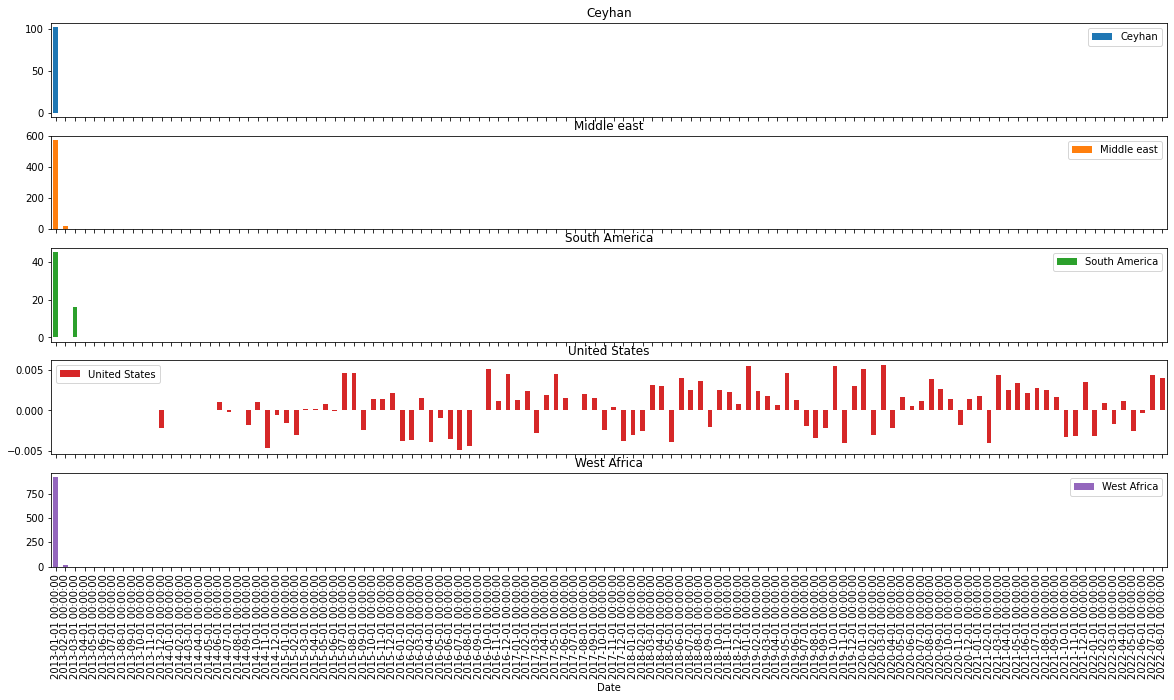

In [89]:
deltas_pivot.plot(kind='bar', subplots=True, figsize=(20,10))

## flows vs DB comparison 

In [105]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [106]:
oecd_europe = ('Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands')

In [114]:
def aggregate_monthly_kbd_db(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped['volume'] = df_grouped['volume']/(df_grouped.index.daysinmonth*1000)
    return df_grouped

In [197]:
def aggregate_daily_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('D').sum().astype(float)
    return df_grouped['volume']

In [198]:
def db_country_imports(origin):
    country_imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
    where origin_country_name = '{origin}' and destination_country_name in {oecd_europe}
    group by voyage_end
    order by voyage_end desc
    '''
    
    ts = aggregate_daily_kbd(ag_get_data(country_imports_query))
    return ts

In [199]:
test = db_country_imports('Nigeria')

In [200]:
test

date
2013-01-13    1052461.0
2013-01-14          0.0
2013-01-15          0.0
2013-01-16          0.0
2013-01-17     515424.0
                ...    
2022-06-29     611275.0
2022-06-30          0.0
2022-07-01          0.0
2022-07-02          0.0
2022-07-03    1040686.0
Freq: D, Name: volume, Length: 3459, dtype: float64

In [159]:
def db_subcont_imports(origin):
    imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
    where origin_subcontinent_name = '{origin}' and destination_country_name in {oecd_europe}
    group by voyage_end
    order by voyage_end desc
    '''
    
    ts = aggregate_monthly_kbd_db(ag_get_data(imports_query))
    return ts

In [163]:
def comparison_db(layer, origin):
    
    ts = clean_ts(flows_client.get(
    from_zones=origin,
    to_zones=["3790"],
    flow_direction = [FlowsDirection.Import],
    with_intra_country=False,
    split = [FlowsSplit.Total],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
    granularity=[FlowsPeriod.Monthly]
    )).set_index('Date')
    
    if layer == 'country':
        db = db_country_imports(origin)
    else:
        db = db_subcont_imports(origin)
    
    comparison= ts.merge(db, left_index=True, right_index=True)
    comparison['delta'] = comparison['volume'] - comparison['Total']
    return comparison

In [164]:
def plot_diffs(layer, c_list):
    delta_list=[]
    for c in c_list:
        delta = comparison_db(layer, c)
        delta['origin']=c
        delta_list.append(delta)
    deltas_df = pd.concat(delta_list)
    deltas_pivot = deltas_df.pivot(columns='origin', values='delta')
    deltas_pivot.plot(kind='bar', subplots=True, figsize=(15,15))
    return deltas_pivot

In [209]:
country_list = ['United States','Nigeria', 'Brazil', 'Russian Federation', 'Libya', 'Algeria', 'Saudi Arabia', 'Iraq', 'Kuwait']
region_list = ['Western Africa', 'South America', 'Northern America', 'Northern Africa', 'Middle East']

In [214]:
def clean_names(str_list):
    new_list=[]
    for i in range(len(str_list)):
        new_list.append(str_list[i].lower())
        new_list[i] = new_list[i].replace(' ','_')
    return new_list

In [215]:
n = clean_names(country_list)

In [217]:
country_list

['United States',
 'Nigeria',
 'Brazil',
 'Russian Federation',
 'Libya',
 'Algeria',
 'Saudi Arabia',
 'Iraq',
 'Kuwait']

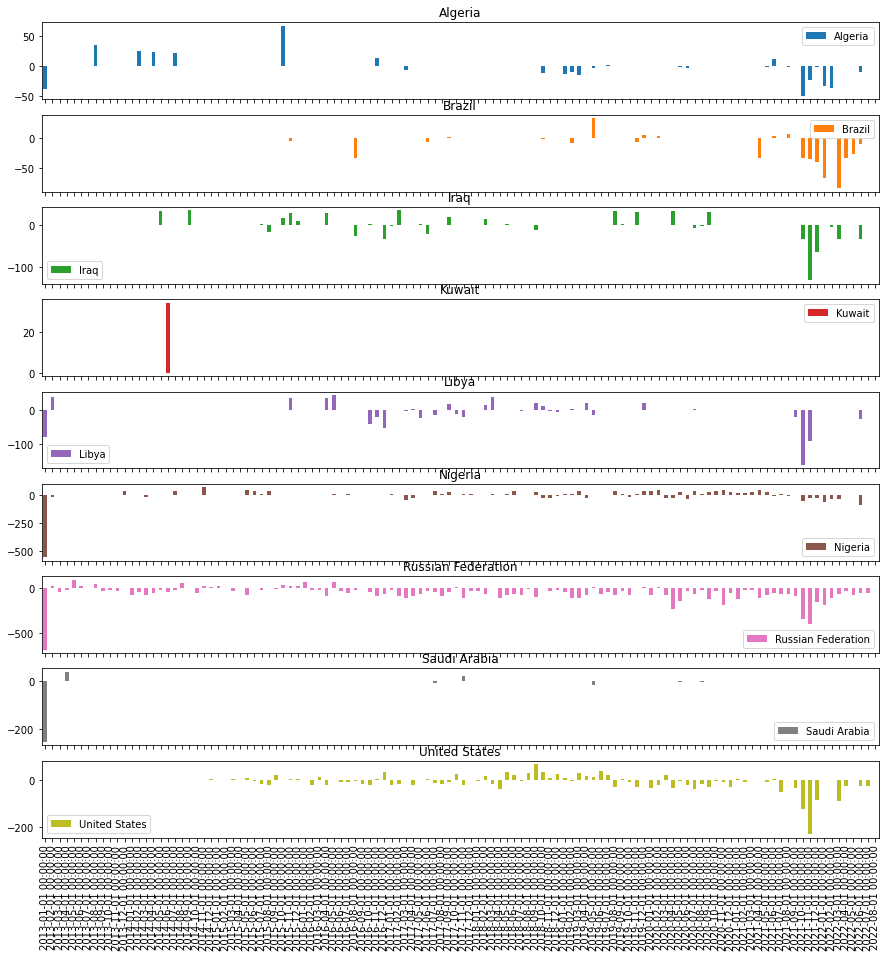

In [165]:
db_diffs = plot_diffs('country', country_list)

In [156]:
db_diffs['2014':].plot(kind='bar', subplots=True, figsize=(15,15))

array([<AxesSubplot:title={'center':'Algeria'}>,
       <AxesSubplot:title={'center':'Brazil'}>,
       <AxesSubplot:title={'center':'Libya'}>,
       <AxesSubplot:title={'center':'Nigeria'}>,
       <AxesSubplot:title={'center':'Russian Federation'}>,
       <AxesSubplot:title={'center':'United States'}>], dtype=object)

In [172]:
db_diffs_subcont = plot_diffs('subcont', region_list)

In [173]:
db_diffs_subcont['2014':].plot(kind='bar', subplots=True, figsize=(15,15))

array([<AxesSubplot:title={'center':'Middle East'}>,
       <AxesSubplot:title={'center':'Northern Africa'}>,
       <AxesSubplot:title={'center':'Northern America'}>,
       <AxesSubplot:title={'center':'South America'}>,
       <AxesSubplot:title={'center':'Western Africa'}>], dtype=object)

In [ ]:
test = ag_get_data()